# Finetuning on 8 worse basins

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read the Original Trained Models

In [7]:
# Old results for the trained model everywhere
old_results = pd.read_csv(data_dir / "RUNOFF/ORIGINAL_LSTM_RESULTS.csv")
old_results.head()

,station_id,nse,kge,mse,bias,log_nse,inv_kge
0,1001,0.876090,0.920412,0.509755,4.266320,0.785360,0.920412
1,2001,0.796159,0.737755,1.295476,-12.189085,0.885491,0.737755
2,2002,0.799168,0.721571,2.248968,-7.375567,0.846839,0.721571
3,3003,0.878744,0.851921,4.253648,-0.086631,0.875849,0.851921
4,4001,0.872644,0.860455,1.789749,-3.644160,0.801445,0.860455


In [8]:
old_df = pd.read_csv(data_dir / "runs/ensemble/data_ENS.csv", usecols=[1, 2, 3, 4])
old_df["time"] = pd.to_datetime(old_df["time"])
old_ds = old_df.set_index(["station_id", "time"]).to_xarray()

In [9]:
old_ds

<xarray.Dataset>
Dimensions:     (station_id: 669, time: 4018)
Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    obs         (station_id, time) float64 2.14 1.81 4.57 3.3 ... 1.18 1.04 0.94
    sim         (station_id, time) float64 1.831 2.051 2.74 ... 3.052 2.835

# Read finetuned Models

In [139]:
from parse import parse, search, findall, with_pattern

HEAD_ONLY = False
base_run_dir = data_dir / "runs/ensemble_finetune/ALL_FINE"

if HEAD_ONLY:
    finetune_run_dirs = list((data_dir / "runs/ensemble_finetune/ALL_FINE_HEAD").glob("*"))
else:
    finetune_run_dirs = list(base_run_dir.glob("*"))

In [140]:
dirs = finetune_run_dirs
# dirs = list((data_dir / "runs/ensemble_finetune/ALL_FINE_HEAD").glob("*"))

logs = [list(d.glob("*/output.log")) for d in dirs]
flat_logs = [log for sublist in logs for log in sublist]
flat_str = [str(log.open("rb").read())  for log in flat_logs]
l = flat_str[0]

def parse_logs(log_file: Path) -> pd.DataFrame:
    log_str = str(log_file.open("rb").read())
    # get basin/epoch
    ens = search("ensemble{:d}", log_file.parents[0].name)[0]
    basin = search("_{:d}_", log_file.parents[0].name)[0]

    # get epoch performance
    epochs = dict([f for f in findall("Epoch {} average loss: {:f}", log_str)])
    # get validation performance
    valid_nse = [f[0] for f in findall("NSE: {:f}", log_str)]
    
    df = pd.DataFrame(
        dict(
            nse=valid_nse, 
            epoch=[(i + 1) * 3 for i in range(len(valid_nse))], 
            basin=[basin for _ in range(len(valid_nse))], 
            ensemble=[ens for _ in range(len(valid_nse))]
        )
    )
    return df

In [141]:
train_nse = pd.concat([parse_logs(l) for l in flat_logs])
train_nse.head()

,nse,epoch,basin,ensemble
0,0.60557,3,54052,4
1,0.13998,6,54052,4
2,0.24293,9,54052,4
3,0.00963,12,54052,4
4,0.04115,15,54052,4


In [142]:
train_nse[train_nse.groupby(['basin', 'ensemble'])['nse'].transform(max) == train_nse['nse']]

,nse,epoch,basin,ensemble
0,0.60557,3,54052,4
3,0.57990,12,54052,2
0,0.58342,3,54052,6
3,0.45635,12,54052,8
0,0.54712,3,54052,1
...,...,...,...,...
3,0.89275,12,42016,7
2,0.91867,9,42016,5
2,0.91827,9,42016,6
5,0.90717,18,42016,2


In [143]:
train_nse.groupby("basin").mean()["nse"]

basin
28050    0.903797
33054    0.826737
34004    0.901293
34008    0.855432
40018    0.894460
41004    0.578555
41019    0.587396
42016    0.897439
54052    0.367127
Name: nse, dtype: float64

In [144]:
all_sim_ds = []
for run_dir in finetune_run_dirs:
    try:
        ds = xr.open_dataset(run_dir / "results.nc")
        sim_da = ds.rename({"discharge_spec_sim": "sim", "discharge_spec_obs": "obs"})
        all_sim_ds.append(sim_da)
    except FileNotFoundError:
        print(run_dir)
        pass
    
finetuned_basins = xr.merge(all_sim_ds)

In [145]:
finetuned_basins

<xarray.Dataset>
Dimensions:     (station_id: 9, time: 4018)
Coordinates:
  * station_id  (station_id) object '28050' '33054' '34004' ... '42016' '54052'
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    obs         (station_id, time) float32 0.82000005 0.89000005 ... 0.65 0.63
    sim         (station_id, time) float32 0.7906009 1.3858367 ... 1.0268576

# Errors

In [146]:
from scripts.drafts.calculate_error_scores import calculate_errors, error_func

In [147]:
lstm_df = calculate_errors(finetuned_basins).set_index("station_id")
lstm_df.index = [int(sid) for sid in lstm_df.index]
lstm_df["rmse"] = np.sqrt(lstm_df["mse"])

In [148]:
# Old results for the trained model everywhere
old_results = pd.read_csv(data_dir / "RUNOFF/ORIGINAL_LSTM_RESULTS.csv").set_index("station_id")
old_results = old_results.loc[lstm_df.index]
old_results

,nse,kge,mse,bias,log_nse,inv_kge
28050,0.647920,0.823971,0.090677,-0.404808,0.851086,0.823971
33054,0.639360,0.734942,0.063533,-19.012350,0.554454,0.734942
34004,0.511092,0.668608,0.070346,4.208461,0.742736,0.668608
34008,0.446254,0.677893,0.040655,-19.997403,0.315443,0.677893
40018,0.602721,0.687930,0.073213,-29.645898,-0.176702,0.687930
41004,0.163422,0.066332,0.316549,83.791406,0.195943,0.066332
41019,0.473190,0.510320,1.442063,16.146635,0.937176,0.510320
42016,0.871977,0.774544,0.051752,-6.389773,0.891680,0.774544
54052,0.421075,0.415506,0.271508,52.667519,0.299332,0.415506


In [149]:
lstm_df

,nse,kge,mse,bias,log_nse,inv_kge,rmse
28050,0.635753,0.792474,0.093811,1.028144,0.851388,0.792474,0.306286
33054,0.640881,0.779381,0.063266,-17.708814,0.539160,0.779381,0.251527
34004,0.498225,0.646196,0.072198,4.681885,0.731263,0.646196,0.268696
34008,0.492895,0.702531,0.037230,-19.023758,0.370587,0.702531,0.192952
40018,0.620635,0.689642,0.069912,-30.162156,-0.051452,0.689642,0.264408
41004,0.341785,0.200300,0.249059,73.386264,0.366716,0.200300,0.499058
41019,0.032875,0.266495,2.647361,22.769201,0.928797,0.266495,1.627071
42016,0.864647,0.769367,0.054715,-4.712236,0.882842,0.769367,0.233912
54052,0.168291,0.331255,0.390060,53.270626,0.209564,0.331255,0.624548


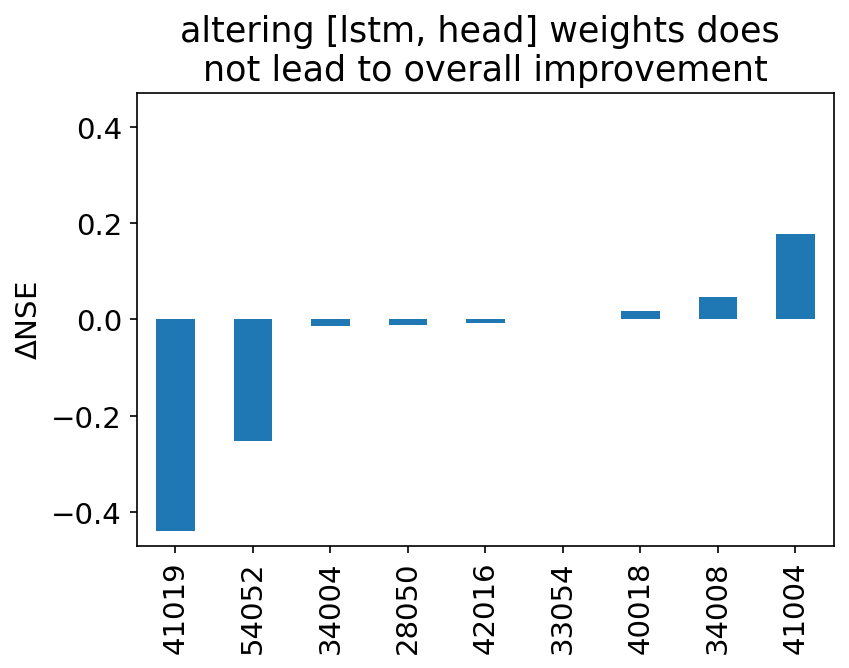

In [150]:
(lstm_df["nse"] - old_results["nse"]).sort_values().plot(kind="bar")
ax = plt.gca()
yval = np.abs(ax.get_ylim()).max()
ax.set_ylim(-yval, yval);
if HEAD_ONLY:
    ax.set_title("altering [head] weights leads \nto a mixed performance impact")
else:
    ax.set_title("altering [lstm, head] weights does \nnot lead to overall improvement")
ax.set_ylabel("$\Delta$NSE");

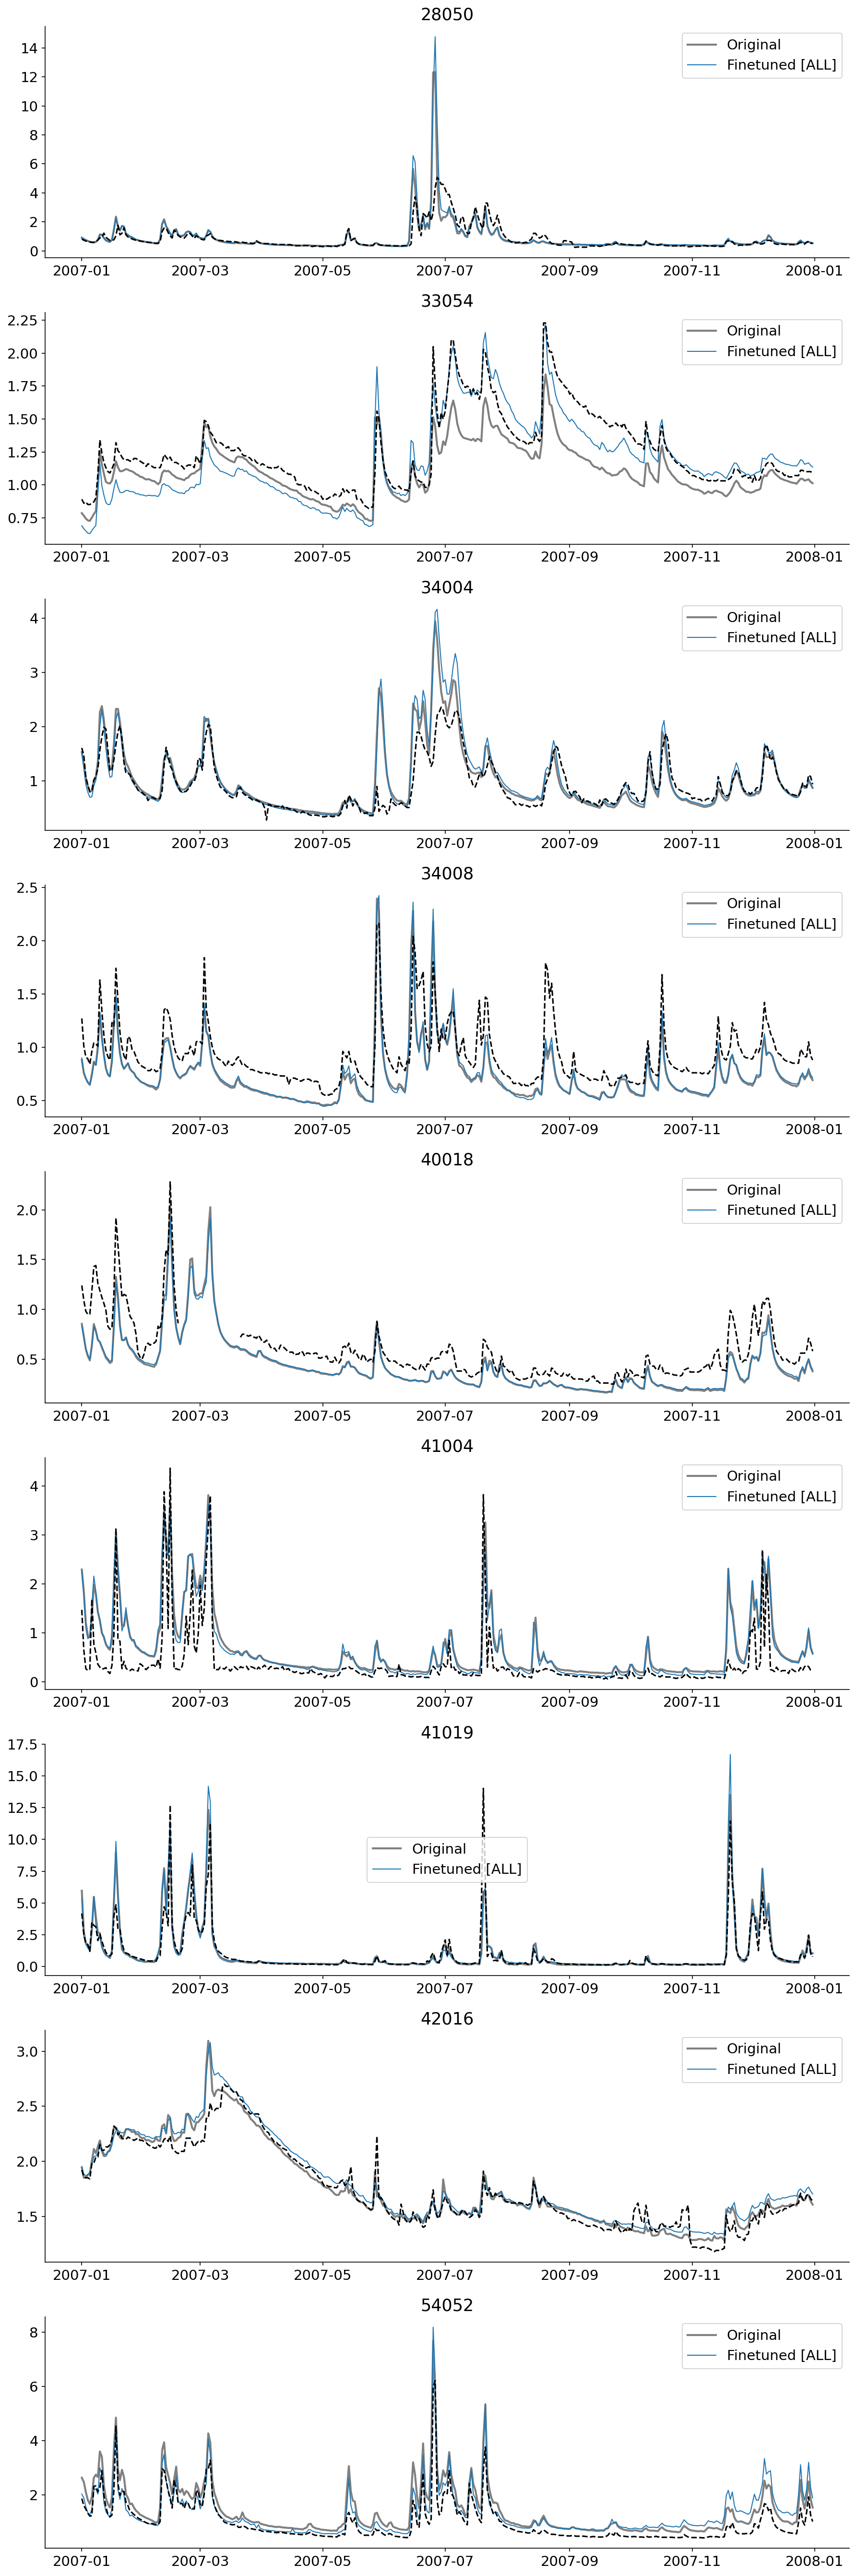

In [151]:
year = 2007

INDIVIDUAL_PLOTS = False
if not INDIVIDUAL_PLOTS:
    f, axs = plt.subplots(9, 1, figsize=(12, 4*9))

for ix, basin in enumerate(finetuned_basins.station_id):
    if INDIVIDUAL_PLOTS:
        f, ax = plt.subplots(figsize=(12, 4))
    else:
        ax = axs[ix]
    df = finetuned_basins.sel(time=str(year)).sel(station_id=basin).drop("station_id").to_dataframe()
    orig = old_ds.sel(station_id=int(basin), time=str(year)).drop('station_id').to_dataframe()

    ax.plot(df.index, orig["sim"], label="Original", linewidth=2, color="grey")
    ax.plot(df.index, df["sim"], label="Finetuned [HEAD]" if HEAD_ONLY else "Finetuned [ALL]", linewidth=1, color="C0")

    ax.plot(df.index, df["obs"], ls="--", color="k")

    ax.legend()
    ax.set_title(int(basin.values))
    sns.despine()
    
plt.tight_layout()

In [152]:
assert False, "Do you want to finish the notebook?"

AssertionError: Do you want to finish the notebook?

# FUSE Data

In [ ]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

In [ ]:
fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))

In [ ]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["discharge_spec"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

In [ ]:
fuse_data

# Match Stations / Times

In [ ]:
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)

# FUSE - Calculate from Sim

In [ ]:
from scripts.drafts.calculate_error_scores import FuseErrors

In [ ]:
fuse_errors_fp = data_dir / "RUNOFF/0_fuse_errors.pkl"
fuse_class_fp = data_dir / "RUNOFF/0_fuse_class.pkl"

if not (fuse_errors_fp).exists() or not (fuse_class_fp).exists():
    f_class = FuseErrors(fuse_data)
    fuse_errors = f_class.fuse_errors
    
    pickle.dump(f_class, fuse_class_fp.open("wb"))
    pickle.dump(fuse_errors, fuse_errors_fp.open("wb"))
else:
    f_class = pickle.load(fuse_class_fp.open("rb"))
    fuse_errors = pickle.load(fuse_errors_fp.open("rb"))

In [ ]:
fuse_bias = f_class.get_metric_df("bias")
fuse_nse_df = f_class.get_metric_df("nse")
fuse_kge_df = f_class.get_metric_df("kge")
fuse_kge_df.head()

In [ ]:
model = "VIC"
vic_data = f_class.get_model_df(model)
vic_data.head()

# Compare the results

In [ ]:
display(fuse_nse_df.loc[lstm_df.index])
display(old_results.set_index("station_id").loc[lstm_df.index])
display(lstm_df)

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

df = lstm_preds.sel(time="2007").isel(station_id=0).drop("station_id").to_dataframe()
orig = old_ds.sel(station_id=lstm_ensemble.station_id, time="2007").drop('station_id').to_dataframe()

ax.plot(df.index, df["obs"], ls="--", color="k")
ax.plot(df.index, df["sim"], label="Finetuned")
ax.plot(df.index, orig["sim"], label="Original")
ax.legend()